# Week 3: Using RNNs to predict time series

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week3/Labs/C4W3_Assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete some of the cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and also refrain from adding any new cells. **Once you have passed this assignment** and want to experiment with any of the locked cells, you may follow the instructions at the bottom of this notebook._

In [1]:
import tensorflow as tf
from keras import Sequential, Input, layers, callbacks, optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

2024-06-14 13:14:58.939682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    sns.set_style("whitegrid")
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")

def trend(time, slope=0):
    
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    
    season_time = ((time + phase) % period) / period
    
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    
    return rnd.randn(len(time)) * noise_level

You will be generating the same time series data as in last week's assignment.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the first week of the course.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).



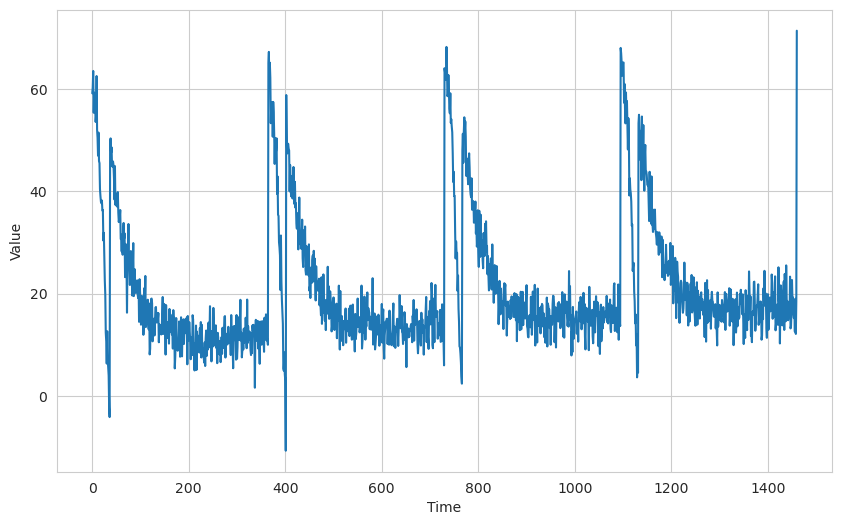

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:



In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

2024-06-14 13:15:01.403727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2133 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture. Unlike previous weeks or courses in which you define your layers and compile the model in the same function, here you will first need to complete the `create_uncompiled_model` function below. 

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:
- Fill in the `Lambda` layers at the beginning and end of the network with the correct lamda functions.
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.
- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.

In [6]:
def create_uncompiled_model():
    ### START CODE HERE
    
    model = Sequential([Input(shape=(None,)),
                        layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                        layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
                        layers.Bidirectional(layers.LSTM(32)),
                        layers.Dense(1),
                        layers.Lambda(lambda x: x * 100.0)]) 
    
    ### END CODE HERE

    return model

In [7]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

     26/Unknown 0s 2ms/step  

2024-06-14 13:15:01.897479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Your current architecture is compatible with the windowed dataset! :)


2024-06-14 13:15:02.181603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [8]:
def adjust_learning_rate():
    model = create_uncompiled_model()
    
    lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [9]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 51.6279 - mae: 52.1279 - learning_rate: 1.0000e-06
Epoch 2/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 50.1630 - mae: 50.6630

2024-06-14 13:15:05.705647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:05.705676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.1319 - mae: 50.6319 - learning_rate: 1.1220e-06
Epoch 3/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.1963 - mae: 49.6963

2024-06-14 13:15:05.940996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:05.941048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.9852 - mae: 49.4852 - learning_rate: 1.2589e-06
Epoch 4/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48.0907 - mae: 48.5907

2024-06-14 13:15:06.174214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:06.174262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.9093 - mae: 48.4093 - learning_rate: 1.4125e-06
Epoch 5/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.1988 - mae: 46.6988

2024-06-14 13:15:06.408280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:06.408342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.1388 - mae: 46.6388 - learning_rate: 1.5849e-06
Epoch 6/100
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45.4448 - mae: 45.9448 

2024-06-14 13:15:06.648216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:06.648255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44.7674 - mae: 45.2674 - learning_rate: 1.7783e-06
Epoch 7/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.7287 - mae: 44.2287

2024-06-14 13:15:06.929493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:06.929555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.2525 - mae: 43.7525 - learning_rate: 1.9953e-06
Epoch 8/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41.2925 - mae: 41.7925

2024-06-14 13:15:07.162332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:07.162365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.9167 - mae: 41.4167 - learning_rate: 2.2387e-06
Epoch 9/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.4075 - mae: 40.9075

2024-06-14 13:15:07.395886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:07.395987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.4581 - mae: 39.9581 - learning_rate: 2.5119e-06
Epoch 10/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.3595 - mae: 36.8595

2024-06-14 13:15:07.629113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:07.629148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.9488 - mae: 36.4488 - learning_rate: 2.8184e-06
Epoch 11/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.8424 - mae: 33.3423

2024-06-14 13:15:07.867027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:07.867054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32.6525 - mae: 33.1523 - learning_rate: 3.1623e-06
Epoch 12/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.5330 - mae: 30.0330

2024-06-14 13:15:08.148638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:08.148662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.1695 - mae: 29.6695 - learning_rate: 3.5481e-06
Epoch 13/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26.4805 - mae: 26.9805

2024-06-14 13:15:08.386563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:08.386593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.9246 - mae: 26.4246 - learning_rate: 3.9811e-06
Epoch 14/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.0523 - mae: 22.5523

2024-06-14 13:15:08.623015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:08.623063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.5476 - mae: 22.0472 - learning_rate: 4.4668e-06
Epoch 15/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.1977 - mae: 17.6916

2024-06-14 13:15:08.857725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:08.857760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.6876 - mae: 17.1815 - learning_rate: 5.0119e-06
Epoch 16/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.4497 - mae: 12.9295

2024-06-14 13:15:09.094304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:09.094345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.3440 - mae: 12.8256 - learning_rate: 5.6234e-06
Epoch 17/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.2772 - mae: 10.7610

2024-06-14 13:15:09.330499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:09.330533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.2985 - mae: 10.7816 - learning_rate: 6.3096e-06
Epoch 18/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.4763 - mae: 10.9627

2024-06-14 13:15:09.606679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:09.606713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.0756 - mae: 10.5613 - learning_rate: 7.0795e-06
Epoch 19/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3626 - mae: 9.8493 

2024-06-14 13:15:09.846473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:09.846502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1950 - mae: 9.6798 - learning_rate: 7.9433e-06
Epoch 20/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0892 - mae: 9.5697  

2024-06-14 13:15:10.081664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:10.081718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7491 - mae: 9.2300 - learning_rate: 8.9125e-06
Epoch 21/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3763 - mae: 7.8562

2024-06-14 13:15:10.319472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:10.319526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4717 - mae: 7.9518 - learning_rate: 1.0000e-05
Epoch 22/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4278 - mae: 7.9072

2024-06-14 13:15:10.559276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:10.559304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2791 - mae: 7.7568 - learning_rate: 1.1220e-05
Epoch 23/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9517 - mae: 6.4276

2024-06-14 13:15:10.795877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:10.795908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0657 - mae: 6.5402 - learning_rate: 1.2589e-05
Epoch 24/100
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7494 - mae: 6.2241

2024-06-14 13:15:11.030419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:11.030450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8299 - mae: 6.3032 - learning_rate: 1.4125e-05
Epoch 25/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9096 - mae: 5.3817

2024-06-14 13:15:11.303428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:11.303459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0472 - mae: 5.5184 - learning_rate: 1.5849e-05
Epoch 26/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4817 - mae: 4.9528

2024-06-14 13:15:11.541893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:11.541960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6063 - mae: 5.0768 - learning_rate: 1.7783e-05
Epoch 27/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5492 - mae: 5.0144

2024-06-14 13:15:11.777187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:11.777241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5063 - mae: 4.9708 - learning_rate: 1.9953e-05
Epoch 28/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8198 - mae: 4.2914

2024-06-14 13:15:12.019733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:12.019771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1391 - mae: 4.6085 - learning_rate: 2.2387e-05
Epoch 29/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2901 - mae: 4.7392 

2024-06-14 13:15:12.258145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:12.258179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2787 - mae: 4.7354 - learning_rate: 2.5119e-05
Epoch 30/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9099 - mae: 4.3776

2024-06-14 13:15:12.523998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:12.524021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0254 - mae: 4.4913 - learning_rate: 2.8184e-05
Epoch 31/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0240 - mae: 4.4807

2024-06-14 13:15:12.764275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:12.764318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0602 - mae: 4.5201 - learning_rate: 3.1623e-05
Epoch 32/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5775 - mae: 4.0372

2024-06-14 13:15:13.002974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:13.003004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7396 - mae: 4.2025 - learning_rate: 3.5481e-05
Epoch 33/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4791 - mae: 3.9460

2024-06-14 13:15:13.240875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:13.240897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6636 - mae: 4.1307 - learning_rate: 3.9811e-05
Epoch 34/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5756 - mae: 4.0420

2024-06-14 13:15:13.476556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:13.476615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6460 - mae: 4.1116 - learning_rate: 4.4668e-05
Epoch 35/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8136 - mae: 4.2828

2024-06-14 13:15:13.709133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:13.709168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7638 - mae: 4.2319 - learning_rate: 5.0119e-05
Epoch 36/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5704 - mae: 4.0324

2024-06-14 13:15:13.981677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:13.981740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6278 - mae: 4.0930 - learning_rate: 5.6234e-05
Epoch 37/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5076 - mae: 3.9729

2024-06-14 13:15:14.225942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:14.225973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5164 - mae: 3.9822 - learning_rate: 6.3096e-05
Epoch 38/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4868 - mae: 3.9505

2024-06-14 13:15:14.469924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:14.469958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4988 - mae: 3.9612 - learning_rate: 7.0795e-05
Epoch 39/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6903 - mae: 4.1552

2024-06-14 13:15:14.707189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:14.707226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6622 - mae: 4.1264 - learning_rate: 7.9433e-05
Epoch 40/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1358 - mae: 3.6026

2024-06-14 13:15:14.950650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:14.950679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2199 - mae: 3.6864 - learning_rate: 8.9125e-05
Epoch 41/100
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5090 - mae: 3.9807  

2024-06-14 13:15:15.187819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:15.187852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4056 - mae: 3.8750 - learning_rate: 1.0000e-04
Epoch 42/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1463 - mae: 3.6145

2024-06-14 13:15:15.490602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:15.490633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2063 - mae: 3.6740 - learning_rate: 1.1220e-04
Epoch 43/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2666 - mae: 3.7382

2024-06-14 13:15:15.728215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:15.728252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2393 - mae: 3.7094 - learning_rate: 1.2589e-04
Epoch 44/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0759 - mae: 3.5402

2024-06-14 13:15:15.961577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:15.961631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1623 - mae: 3.6264 - learning_rate: 1.4125e-04
Epoch 45/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3256 - mae: 3.7985

2024-06-14 13:15:16.202651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:16.202697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2776 - mae: 3.7484 - learning_rate: 1.5849e-04
Epoch 46/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7895 - mae: 3.2563

2024-06-14 13:15:16.436553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:16.436583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9368 - mae: 3.4045 - learning_rate: 1.7783e-04
Epoch 47/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7954 - mae: 3.2550

2024-06-14 13:15:16.721501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:16.721564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9286 - mae: 3.3899 - learning_rate: 1.9953e-04
Epoch 48/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3338 - mae: 3.7977

2024-06-14 13:15:16.962502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:16.962593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2957 - mae: 3.7597 - learning_rate: 2.2387e-04
Epoch 49/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8574 - mae: 3.3159

2024-06-14 13:15:17.194425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:17.194454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8775 - mae: 3.3354 - learning_rate: 2.5119e-04
Epoch 50/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2916 - mae: 3.7609

2024-06-14 13:15:17.423440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:17.423469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1590 - mae: 3.6271 - learning_rate: 2.8184e-04
Epoch 51/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9335 - mae: 3.3948

2024-06-14 13:15:17.652467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:17.652500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8999 - mae: 3.3616 - learning_rate: 3.1623e-04
Epoch 52/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8422 - mae: 3.2977

2024-06-14 13:15:17.886604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:17.886638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9503 - mae: 3.4087 - learning_rate: 3.5481e-04
Epoch 53/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3804 - mae: 3.8449

2024-06-14 13:15:18.123784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:18.123859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2936 - mae: 3.7602 - learning_rate: 3.9811e-04
Epoch 54/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6786 - mae: 3.1443

2024-06-14 13:15:18.407605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:18.407631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7758 - mae: 3.2423 - learning_rate: 4.4668e-04
Epoch 55/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4966 - mae: 3.9722

2024-06-14 13:15:18.646484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:18.646517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3223 - mae: 3.7956 - learning_rate: 5.0119e-04
Epoch 56/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5950 - mae: 3.0449

2024-06-14 13:15:18.879537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:18.879592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6999 - mae: 3.1548 - learning_rate: 5.6234e-04
Epoch 57/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1541 - mae: 3.6210

2024-06-14 13:15:19.112020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:19.112093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1069 - mae: 3.5735 - learning_rate: 6.3096e-04
Epoch 58/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3231 - mae: 3.7981

2024-06-14 13:15:19.346052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:19.346132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1696 - mae: 3.6412 - learning_rate: 7.0795e-04
Epoch 59/100
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2793 - mae: 3.7464 

2024-06-14 13:15:19.576488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:19.576517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3997 - mae: 3.8702 - learning_rate: 7.9433e-04
Epoch 60/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7997 - mae: 3.2610

2024-06-14 13:15:19.848073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:19.848105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8443 - mae: 3.3041 - learning_rate: 8.9125e-04
Epoch 61/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2059 - mae: 3.6764

2024-06-14 13:15:20.085111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:20.085160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1062 - mae: 3.5751 - learning_rate: 0.0010
Epoch 62/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4946 - mae: 3.9672

2024-06-14 13:15:20.319265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:20.319296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3242 - mae: 3.7946 - learning_rate: 0.0011
Epoch 63/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6548 - mae: 3.1097

2024-06-14 13:15:20.556738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:20.556790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7636 - mae: 3.2209 - learning_rate: 0.0013
Epoch 64/100
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7156 - mae: 3.1840

2024-06-14 13:15:20.788750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:20.788792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7747 - mae: 3.2413 - learning_rate: 0.0014
Epoch 65/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0569 - mae: 3.5290

2024-06-14 13:15:21.069277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:21.069306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0068 - mae: 3.4771 - learning_rate: 0.0016
Epoch 66/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9212 - mae: 3.3883

2024-06-14 13:15:21.306643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:21.306666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9738 - mae: 3.4411 - learning_rate: 0.0018
Epoch 67/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8345 - mae: 3.3031

2024-06-14 13:15:21.540595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:21.540633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9166 - mae: 3.3856 - learning_rate: 0.0020
Epoch 68/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6214 - mae: 3.0901

2024-06-14 13:15:21.779862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:21.779915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6782 - mae: 3.1451 - learning_rate: 0.0022
Epoch 69/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4881 - mae: 2.9504

2024-06-14 13:15:22.023187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:22.023221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5980 - mae: 3.0622 - learning_rate: 0.0025
Epoch 70/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4038 - mae: 2.8645

2024-06-14 13:15:22.273414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:22.273463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6494 - mae: 3.1129 - learning_rate: 0.0028
Epoch 71/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8136 - mae: 4.2899

2024-06-14 13:15:22.562803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:22.562859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5480 - mae: 4.0208 - learning_rate: 0.0032
Epoch 72/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4236 - mae: 2.8824

2024-06-14 13:15:22.829433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:22.829489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5913 - mae: 3.0515 - learning_rate: 0.0035
Epoch 73/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4592 - mae: 3.9350

2024-06-14 13:15:23.085431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:23.085455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4223 - mae: 3.8960 - learning_rate: 0.0040
Epoch 74/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9671 - mae: 3.4375

2024-06-14 13:15:23.335558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:23.335593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9549 - mae: 3.4246 - learning_rate: 0.0045
Epoch 75/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3455 - mae: 3.8199

2024-06-14 13:15:23.575998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:23.576072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2289 - mae: 3.7010 - learning_rate: 0.0050
Epoch 76/100
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4125 - mae: 2.8697  

2024-06-14 13:15:23.822684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:23.822709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5469 - mae: 3.0063 - learning_rate: 0.0056
Epoch 77/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4005 - mae: 2.8622

2024-06-14 13:15:24.119628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:24.119657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4759 - mae: 2.9362 - learning_rate: 0.0063
Epoch 78/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7929 - mae: 3.2603

2024-06-14 13:15:24.352013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:24.352039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9683 - mae: 3.4368 - learning_rate: 0.0071
Epoch 79/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8715 - mae: 3.3414

2024-06-14 13:15:24.579533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:24.579626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0216 - mae: 3.4920 - learning_rate: 0.0079
Epoch 80/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1388 - mae: 3.6064

2024-06-14 13:15:24.818859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:24.818925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0616 - mae: 3.5290 - learning_rate: 0.0089
Epoch 81/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3447 - mae: 2.8031

2024-06-14 13:15:25.057379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:25.057403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5431 - mae: 3.0035 - learning_rate: 0.0100
Epoch 82/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6420 - mae: 4.1109

2024-06-14 13:15:25.355078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:25.355102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6100 - mae: 4.0798 - learning_rate: 0.0112
Epoch 83/100
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1850 - mae: 3.6528

2024-06-14 13:15:25.595275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:25.595305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0292 - mae: 3.4971 - learning_rate: 0.0126
Epoch 84/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9815 - mae: 3.4534

2024-06-14 13:15:25.879462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:25.879516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9894 - mae: 3.4595 - learning_rate: 0.0141
Epoch 85/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6540 - mae: 3.1159

2024-06-14 13:15:26.117471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:26.117495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9574 - mae: 3.4231 - learning_rate: 0.0158
Epoch 86/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7214 - mae: 3.1844

2024-06-14 13:15:26.368926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:26.368958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7327 - mae: 3.1960 - learning_rate: 0.0178
Epoch 87/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5576 - mae: 3.0215

2024-06-14 13:15:26.656700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:26.656750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5350 - mae: 2.9981 - learning_rate: 0.0200
Epoch 88/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8564 - mae: 3.3295

2024-06-14 13:15:26.908044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:26.908084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7359 - mae: 3.2050 - learning_rate: 0.0224
Epoch 89/100
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1738 - mae: 3.6467

2024-06-14 13:15:27.152243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:27.152292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0167 - mae: 3.4854 - learning_rate: 0.0251
Epoch 90/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5686 - mae: 3.0363

2024-06-14 13:15:27.417890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:27.417942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7919 - mae: 3.2621 - learning_rate: 0.0282
Epoch 91/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1468 - mae: 3.6246

2024-06-14 13:15:27.701484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:27.701556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0813 - mae: 3.5562 - learning_rate: 0.0316
Epoch 92/100
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1149 - mae: 3.5903

2024-06-14 13:15:27.948037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:27.948072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9767 - mae: 3.4473 - learning_rate: 0.0355
Epoch 93/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0106 - mae: 3.4862

2024-06-14 13:15:28.186779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:28.186823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9244 - mae: 3.3961 - learning_rate: 0.0398
Epoch 94/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6481 - mae: 3.1105

2024-06-14 13:15:28.423902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:28.423937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6622 - mae: 3.1251 - learning_rate: 0.0447
Epoch 95/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8600 - mae: 3.3323

2024-06-14 13:15:28.661569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:28.661631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9273 - mae: 3.3987 - learning_rate: 0.0501
Epoch 96/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7692 - mae: 3.2375

2024-06-14 13:15:28.902334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:28.902420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8448 - mae: 3.3134 - learning_rate: 0.0562
Epoch 97/100
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5821 - mae: 3.0479  

2024-06-14 13:15:29.135085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:29.135115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8885 - mae: 3.3569 - learning_rate: 0.0631
Epoch 98/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2151 - mae: 3.6816

2024-06-14 13:15:29.454615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:29.454657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2694 - mae: 3.7358 - learning_rate: 0.0708
Epoch 99/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9283 - mae: 3.3893

2024-06-14 13:15:29.718576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:29.718599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8915 - mae: 3.3542 - learning_rate: 0.0794
Epoch 100/100
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8597 - mae: 3.3325  

2024-06-14 13:15:29.982154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:29.982194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9048 - mae: 3.3727 - learning_rate: 0.0891


2024-06-14 13:15:30.307418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:30.307475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


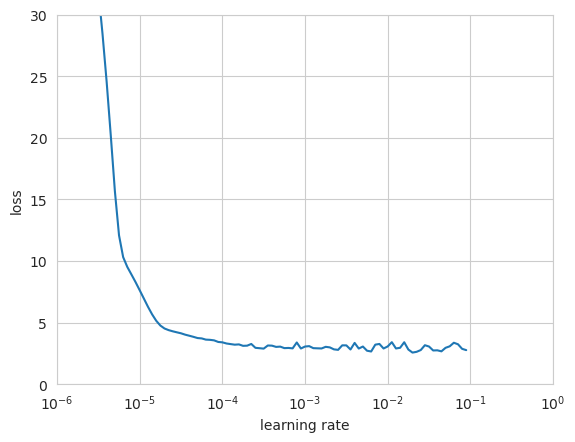

In [10]:
# Plot the loss for every LR
sns.set_style("whitegrid")
plt.figure()
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [11]:
def create_model():
    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=losses.Huber(),
                  optimizer=optimizers.Adam(),
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [12]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 10.5137 - mae: 11.0010
Epoch 2/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7047 - mae: 4.1748

2024-06-14 13:15:33.169264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:33.169287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6598 - mae: 4.1291
Epoch 3/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1146 - mae: 3.5777

2024-06-14 13:15:33.413212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:33.413247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1058 - mae: 3.5697
Epoch 4/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2888 - mae: 3.7578

2024-06-14 13:15:33.662875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:33.662954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3060 - mae: 3.7758
Epoch 5/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0514 - mae: 3.5178

2024-06-14 13:15:33.912411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:33.912470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9846 - mae: 3.4491
Epoch 6/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6413 - mae: 3.1118

2024-06-14 13:15:34.192730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:34.192798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8050 - mae: 3.2751
Epoch 7/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8402 - mae: 3.3098

2024-06-14 13:15:34.441606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:34.441639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8089 - mae: 3.2771
Epoch 8/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9786 - mae: 3.4475

2024-06-14 13:15:34.679299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:34.679321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9091 - mae: 3.3755
Epoch 9/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6376 - mae: 3.1007

2024-06-14 13:15:34.912046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:34.912076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6255 - mae: 3.0880
Epoch 10/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7141 - mae: 3.1831

2024-06-14 13:15:35.145070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:35.145103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6930 - mae: 3.1614
Epoch 11/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1252 - mae: 3.5937

2024-06-14 13:15:35.379295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:35.379325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9918 - mae: 3.4588
Epoch 12/50
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7633 - mae: 3.2204  

2024-06-14 13:15:35.618499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:35.618524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5570 - mae: 3.0129
Epoch 13/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8077 - mae: 3.2663

2024-06-14 13:15:35.936030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:35.936100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7780 - mae: 3.2400
Epoch 14/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8344 - mae: 3.2961

2024-06-14 13:15:36.177962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:36.178125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7726 - mae: 3.2341
Epoch 15/50
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1652 - mae: 3.6324

2024-06-14 13:15:36.421154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:36.421192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0141 - mae: 3.4798
Epoch 16/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5203 - mae: 2.9754

2024-06-14 13:15:36.673317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:36.673336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5284 - mae: 2.9854
Epoch 17/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3364 - mae: 3.8023

2024-06-14 13:15:36.908524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:36.908558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1572 - mae: 3.6217
Epoch 18/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1183 - mae: 3.5890

2024-06-14 13:15:37.202873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:37.202912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0583 - mae: 3.5272
Epoch 19/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6449 - mae: 3.1071

2024-06-14 13:15:37.439847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:37.439882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6231 - mae: 3.0849
Epoch 20/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5590 - mae: 3.0180

2024-06-14 13:15:37.685106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:37.685174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5504 - mae: 3.0082
Epoch 21/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4833 - mae: 2.9349

2024-06-14 13:15:37.929978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:37.930012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5640 - mae: 3.0186
Epoch 22/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5004 - mae: 2.9671

2024-06-14 13:15:38.168569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:38.168612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4851 - mae: 2.9495
Epoch 23/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5078 - mae: 2.9634

2024-06-14 13:15:38.407066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:38.407096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5135 - mae: 2.9689
Epoch 24/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3745 - mae: 2.8288

2024-06-14 13:15:38.649372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:38.649398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4778 - mae: 2.9350
Epoch 25/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6538 - mae: 3.1157

2024-06-14 13:15:38.948768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:38.948813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6049 - mae: 3.0671
Epoch 26/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6423 - mae: 3.1060

2024-06-14 13:15:39.182204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:39.182249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6229 - mae: 3.0863
Epoch 27/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3055 - mae: 2.7661

2024-06-14 13:15:39.411280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:39.411344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3632 - mae: 2.8240
Epoch 28/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5907 - mae: 3.0441

2024-06-14 13:15:39.646932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:39.646979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5136 - mae: 2.9696
Epoch 29/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2372 - mae: 2.6851

2024-06-14 13:15:39.895079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:39.895131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2890 - mae: 2.7378
Epoch 30/50
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1796 - mae: 2.6465

2024-06-14 13:15:40.173263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:40.173299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3409 - mae: 2.8079
Epoch 31/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5103 - mae: 2.9665

2024-06-14 13:15:40.461057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:40.461083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:15:40.461101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1535436420096472695


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5433 - mae: 3.0011
Epoch 32/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8392 - mae: 3.3109

2024-06-14 13:15:40.704116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:40.704140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 13727768728194666706
2024-06-14 13:15:40.704144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 163285722832277999
2024-06-14 13:15:40.704149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:15:40.704163: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3946474713953387243
2024-06-14 13:15:40.704168: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14042527009136890

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7135 - mae: 3.1826
Epoch 33/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4958 - mae: 2.9590

2024-06-14 13:15:40.949731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:40.949762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5164 - mae: 2.9787
Epoch 34/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4149 - mae: 2.8702

2024-06-14 13:15:41.203173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:41.203203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4479 - mae: 2.9043
Epoch 35/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5223 - mae: 2.9782

2024-06-14 13:15:41.439734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:41.439763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5448 - mae: 3.0028
Epoch 36/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3524 - mae: 2.7999

2024-06-14 13:15:41.719024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:41.719070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3898 - mae: 2.8410
Epoch 37/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5009 - mae: 2.9639

2024-06-14 13:15:41.957232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:41.957255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4963 - mae: 2.9575
Epoch 38/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6340 - mae: 3.1024

2024-06-14 13:15:42.189547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:42.189568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:15:42.189583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1535436420096472695


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5789 - mae: 3.0454
Epoch 39/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4271 - mae: 2.8764

2024-06-14 13:15:42.419866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:42.419889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:15:42.419904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1535436420096472695


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4272 - mae: 2.8786
Epoch 40/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6686 - mae: 3.1241

2024-06-14 13:15:42.651106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:42.651153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6398 - mae: 3.0963
Epoch 41/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4305 - mae: 2.8845

2024-06-14 13:15:42.886531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:42.886587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4513 - mae: 2.9055
Epoch 42/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3507 - mae: 2.8146

2024-06-14 13:15:43.169417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:43.169447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4694 - mae: 2.9331
Epoch 43/50
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4557 - mae: 2.9169

2024-06-14 13:15:43.431704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:43.431757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4376 - mae: 2.8972
Epoch 44/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5729 - mae: 3.0457

2024-06-14 13:15:43.667774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:43.667801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5495 - mae: 3.0192
Epoch 45/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3608 - mae: 2.8260

2024-06-14 13:15:43.908656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:43.908708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3938 - mae: 2.8553
Epoch 46/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7220 - mae: 3.1941

2024-06-14 13:15:44.146999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:44.147032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6669 - mae: 3.1378
Epoch 47/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3486 - mae: 2.8078 

2024-06-14 13:15:44.378420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:44.378444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:15:44.378459: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3946474713953387243
2024-06-14 13:15:44.378466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1535436420096472695


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3226 - mae: 2.7801
Epoch 48/50
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4038 - mae: 2.8524

2024-06-14 13:15:44.651650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:44.651681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3510 - mae: 2.8021
Epoch 49/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6106 - mae: 3.0793

2024-06-14 13:15:44.891224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:44.891272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6019 - mae: 3.0685
Epoch 50/50
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4022 - mae: 2.8634

2024-06-14 13:15:45.134744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:45.134774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4043 - mae: 2.8665


2024-06-14 13:15:45.383075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:15:45.383109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [13]:
def compute_metrics(true_series, forecast):
    mse = metrics.mean_squared_error(true_series, forecast).numpy()
    mae = metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


2024-06-14 13:15:46.009029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


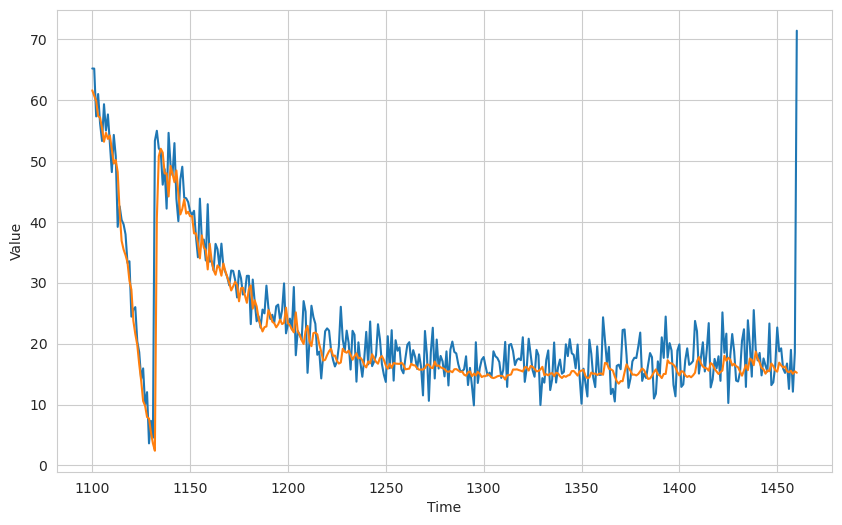

In [15]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

**Expected Output:**

A series similar to this one:

<div>
<img src="./images/expected.png" width="500"/>
</div>

In [16]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 29.71, mae: 3.17 for forecast


**To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a `tar` file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy `SavedModel` directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**


- Unlike last week, this time the model is saved using the `SavedModel` format. This is done because the HDF5 format does not fully support `Lambda` layers.

In [17]:
# # Save your model in the SavedModel format
# model.save('./saved_model/my_model')

# # Compress the directory using tar
# ! tar -czvf saved_model.tar.gz saved_model/

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging Tensorflow's layers for sequence modelling such as `RNNs` and `LSTMs`! **This resulted in a forecast that matches (or even surpasses) the one from last week while training for half of the epochs.**

**Keep it up!**